# ITI110 Model Training - hourly / loss: Poisson (N-BEATSx) (Mag)
#### Loss function: Poisson

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [ ]:
import torch

# Test on hourly dataset

### Load data and extract columns required for training

In [ ]:
# Connect to Google Drive

from google.colab import drive
drive.mount('/content/drive')

user_folder = '/content/drive/My Drive/Data/ITI110/'

Mounted at /content/drive


In [ ]:
df = pd.read_csv(user_folder + '2.2 merged_aggregated_hourly_without_block_id.csv')
df['ds'] = pd.to_datetime(df["tstp"], format='%Y-%m-%d %H:%M:%S')
# Extract columns required for training and convert column names to NBEATS config
df_nbeats = df[['ds', 'avg_energy_per_lclid', 'holiday', 'temperature', 'humidity', 'windSpeed']]
df_nbeats.insert(1, 'unique_id', 1)
df_nbeats['unique_id'] = 1
df_nbeats.rename(columns={'avg_energy_per_lclid':'y'}, inplace= True)
df_nbeats.head()


,ds,unique_id,y,holiday,temperature,humidity,windSpeed
0,2011-11-23 09:00:00,1,0.565000,0.0,4.84,0.99,1.78
1,2011-11-23 10:00:00,1,0.251333,0.0,5.74,0.98,1.99
2,2011-11-23 11:00:00,1,0.303286,0.0,7.67,0.88,2.66
3,2011-11-23 12:00:00,1,0.658900,0.0,8.84,0.85,2.80
4,2011-11-23 13:00:00,1,0.481769,0.0,9.87,0.82,3.12


In [ ]:
df_nbeats.dtypes

ds             datetime64[ns]
unique_id               int64
y                     float64
holiday               float64
temperature           float64
humidity              float64
windSpeed             float64
dtype: object

In [ ]:
df_nbeats['y'] = df_nbeats['y'].astype('float')
df_nbeats['holiday'] = df_nbeats['holiday'].astype('float')
df_nbeats['temperature'] = df_nbeats['temperature'].astype('float')
df_nbeats['humidity'] = df_nbeats['humidity'].astype('float')
df_nbeats['windSpeed'] = df_nbeats['windSpeed'].astype('float')


### Check on missing data and compare different methods of imputation

In [ ]:
df_nbeats[df_nbeats.isna().any(axis=1)]

,ds,unique_id,y,holiday,temperature,humidity,windSpeed
15758,2013-09-09 23:00:00,1,0.294621,0.0,NaN,NaN,NaN
15759,2013-09-10 00:00:00,1,0.251980,0.0,NaN,NaN,NaN


In [ ]:
# Apply interpolation on dataset
df_nbeats = df_nbeats.interpolate("ffill")
df_nbeats.isna().any()

ds             False
unique_id      False
y              False
holiday        False
temperature    False
humidity       False
windSpeed      False
dtype: bool

In [ ]:
df_nbeats[df_nbeats.isna().any(axis=1)]

,ds,unique_id,y,holiday,temperature,humidity,windSpeed


### Split data into train and test datasets

In [ ]:
# reserve 7 days *24 hours data for test
# test = 168 data points

In [ ]:
# Test_value: 0.8

test = df_nbeats[len(df_nbeats) - 168:]  # start row: 19696

train_rows = int(0.8*(len(df_nbeats)-168))

train = df_nbeats[:train_rows]
val = df_nbeats[train_rows:-168]

# Check rows
print("dataset size: ", len(df_nbeats))
print("train length: ", len(train))
print("last row of train: ", train.index[-1])
print("val length: ", len(val))
print("first row of val: ", val.index[0])
print("last row of val: ", val.index[-1])
print("test length: ", len(test))
print("first row of test: ", test.index[0])
print("last row of test: ", test.index[-1])

dataset size:  19864
train length:  15756
last row of train:  15755
val length:  3940
first row of val:  15756
last row of val:  19695
test length:  168
first row of test:  19696
last row of test:  19863


In [ ]:
val.tail()

,ds,unique_id,y,holiday,temperature,humidity,windSpeed
19691,2014-02-20 20:00:00,1,0.676087,0.0,7.34,0.80,4.09
19692,2014-02-20 21:00:00,1,0.638370,0.0,6.84,0.80,3.73
19693,2014-02-20 22:00:00,1,0.574031,0.0,6.86,0.81,3.70
19694,2014-02-20 23:00:00,1,0.470768,0.0,6.34,0.83,3.26
19695,2014-02-21 00:00:00,1,0.410864,0.0,6.14,0.81,3.07


In [ ]:
# Not needed. Scaler is built into N-BEATS
# from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import MinMaxScaler

# # Scale the features using MinMaxScaler for normalization
# scaler = MinMaxScaler()
# cols_to_scale = ['temperatureMax', 'humidity', 'windSpeed']
# train[cols_to_scale] = scaler.fit_transform(train[cols_to_scale])
# test[cols_to_scale] = scaler.transform(test[cols_to_scale])

In [ ]:
train.head()

,ds,unique_id,y,holiday,temperature,humidity,windSpeed
0,2011-11-23 09:00:00,1,0.565000,0.0,4.84,0.99,1.78
1,2011-11-23 10:00:00,1,0.251333,0.0,5.74,0.98,1.99
2,2011-11-23 11:00:00,1,0.303286,0.0,7.67,0.88,2.66
3,2011-11-23 12:00:00,1,0.658900,0.0,8.84,0.85,2.80
4,2011-11-23 13:00:00,1,0.481769,0.0,9.87,0.82,3.12


In [ ]:
!pip install neuralforecast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.6/170.6 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.9/800.9 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 11.0 MB/s eta 0:00:00


In [ ]:
!pip install optuna

In [ ]:
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATSx
from neuralforecast.losses.pytorch import DistributionLoss, MAE, MAPE
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import optuna

### Optuna Tuning (Loss Function: Poisson)

In [ ]:
# Create function for Optuna tuning (Poisson)

h = val['ds'].nunique()

def objective(trial):

    input_size = trial.suggest_int('input_size', 1, 60)

    n_blocks_season = trial.suggest_int('n_blocks_season', 1, 3)
    n_blocks_trend = trial.suggest_int('n_blocks_trend', 1, 3)
    n_blocks_identity = trial.suggest_int('n_blocks_ident', 1, 3)

    mlp_units_n = trial.suggest_categorical('mlp_units', [32, 64, 128])
    num_hidden = trial.suggest_int('num_hidden', 1, 3)

    n_harmonics = trial.suggest_int('n_harmonics', 1, 5)
    n_polynomials = trial.suggest_int('n_polynomials', 1, 5)

    scaler_type = trial.suggest_categorical('scaler_type', ['standard', 'robust'])
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


    n_blocks = [n_blocks_season, n_blocks_trend, n_blocks_identity]
    mlp_units=[[mlp_units_n, mlp_units_n]]*num_hidden
    models = [NBEATSx(h=h,input_size=input_size,
                 loss=DistributionLoss(distribution='Poisson', level=[90]),
                 max_steps=100,
                 hist_exog_list=['holiday', 'temperature', 'humidity', 'windSpeed'],
                 futr_exog_list=['holiday', 'temperature', 'humidity', 'windSpeed'],
                 stack_types=['seasonality', 'trend', 'identity'],
                 mlp_units=mlp_units,
                 n_blocks=n_blocks,
                 learning_rate=learning_rate,
                 n_harmonics=n_harmonics,
                 n_polynomials=n_polynomials,
                 scaler_type=scaler_type)
                 ]
    model = NeuralForecast(models=models, freq='H')
    model.fit(train)

    p_poi = model.predict(futr_df=val).reset_index()
    p_poi = p_poi.merge(val[['ds', 'unique_id', 'y']], on=['ds', 'unique_id'], how='left')

    loss = mean_absolute_error(p_poi['y'], p_poi['NBEATSx'])
    rmse = mean_squared_error(p_poi['y'], p_poi['NBEATSx'], squared=False)
    mape = mean_absolute_percentage_error(p_poi['y'], p_poi['NBEATSx'])

    input_size_value.append(input_size)
    n_blocks_season_value.append(n_blocks_season)
    n_blocks_trend_value.append(n_blocks_trend)
    n_blocks_identity_value.append(n_blocks_identity)
    mlp_units_value.append(mlp_units_n)
    num_hidden_value.append(num_hidden)
    n_harmonics_value.append(n_harmonics)
    n_polynomials_value.append(n_polynomials)
    scaler_type_value.append(scaler_type)
    learning_rate_value.append(learning_rate)
    MAE_value.append(loss)
    RMSE_value.append(rmse)
    MAPE_value.append(mape)
    Loss_Fn.append("Poisson")

    return loss

input_size_value = []
n_blocks_season_value = []
n_blocks_trend_value = []
n_blocks_identity_value = []
mlp_units_value = []
num_hidden_value = []
n_harmonics_value = []
n_polynomials_value = []
scaler_type_value = []
learning_rate_value = []
MAE_value = []
RMSE_value = []
MAPE_value = []
Loss_Fn = []

In [ ]:
eval = optuna.create_study(direction='minimize')
eval.optimize(objective, n_trials=30)

[I 2024-02-24 02:30:09,083] A new study created in memory with name: no-name-facc3c80-6795-4202-af46-d2093e1edea2
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 02:30:45,307] Trial 0 finished with value: 0.4501815535515491 and parameters: {'input_size': 14, 'n_blocks_season': 1, 'n_blocks_trend': 1, 'n_blocks_ident': 2, 'mlp_units': 32, 'num_hidden': 2, 'n_harmonics': 4, 'n_polynomials': 1, 'scaler_type': 'robust', 'learning_rate': 0.017889328081622215}. Best is trial 0 with value: 0.4501815535515491.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 02:31:09,307] Trial 1 finished with value: 3.4944973616187407 and parameters: {'input_size': 13, 'n_blocks_season': 2, 'n_blocks_trend': 1, 'n_blocks_ident': 2, 'mlp_units': 128, 'num_hidden': 2, 'n_harmonics': 3, 'n_polynomials': 3, 'scaler_type': 'standard', 'learning_rate': 2.193629220462842e-05}. Best is trial 0 with value: 0.4501815535515491.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 02:31:27,591] Trial 2 finished with value: 0.4501815535515491 and parameters: {'input_size': 37, 'n_blocks_season': 3, 'n_blocks_trend': 1, 'n_blocks_ident': 3, 'mlp_units': 32, 'num_hidden': 2, 'n_harmonics': 1, 'n_polynomials': 5, 'scaler_type': 'robust', 'learning_rate': 0.018913798152187706}. Best is trial 0 with value: 0.4501815535515491.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 02:31:41,336] Trial 3 finished with value: 0.1924861325024658 and parameters: {'input_size': 41, 'n_blocks_season': 1, 'n_blocks_trend': 1, 'n_blocks_ident': 3, 'mlp_units': 128, 'num_hidden': 2, 'n_harmonics': 2, 'n_polynomials': 3, 'scaler_type': 'standard', 'learning_rate': 0.010869661655124875}. Best is trial 3 with value: 0.1924861325024658.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 02:32:21,682] Trial 4 finished with value: 0.4501815535515491 and parameters: {'input_size': 11, 'n_blocks_season': 2, 'n_blocks_trend': 3, 'n_blocks_ident': 3, 'mlp_units': 128, 'num_hidden': 1, 'n_harmonics': 5, 'n_polynomials': 5, 'scaler_type': 'robust', 'learning_rate': 0.008376273523114031}. Best is trial 3 with value: 0.1924861325024658.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 02:32:42,399] Trial 5 finished with value: 0.29746777470518215 and parameters: {'input_size': 57, 'n_blocks_season': 2, 'n_blocks_trend': 3, 'n_blocks_ident': 2, 'mlp_units': 128, 'num_hidden': 1, 'n_harmonics': 2, 'n_polynomials': 4, 'scaler_type': 'standard', 'learning_rate': 0.00010132546515508164}. Best is trial 3 with value: 0.1924861325024658.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 02:33:09,125] Trial 6 finished with value: 0.4501815535515491 and parameters: {'input_size': 42, 'n_blocks_season': 2, 'n_blocks_trend': 1, 'n_blocks_ident': 1, 'mlp_units': 128, 'num_hidden': 1, 'n_harmonics': 3, 'n_polynomials': 1, 'scaler_type': 'robust', 'learning_rate': 0.001824149720894009}. Best is trial 3 with value: 0.1924861325024658.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 02:33:26,978] Trial 7 finished with value: 0.311601892187989 and parameters: {'input_size': 40, 'n_blocks_season': 2, 'n_blocks_trend': 1, 'n_blocks_ident': 2, 'mlp_units': 64, 'num_hidden': 1, 'n_harmonics': 2, 'n_polynomials': 4, 'scaler_type': 'standard', 'learning_rate': 0.00019381200220926908}. Best is trial 3 with value: 0.1924861325024658.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 02:34:19,958] Trial 8 finished with value: 0.4501815535515491 and parameters: {'input_size': 51, 'n_blocks_season': 3, 'n_blocks_trend': 1, 'n_blocks_ident': 3, 'mlp_units': 128, 'num_hidden': 3, 'n_harmonics': 5, 'n_polynomials': 4, 'scaler_type': 'robust', 'learning_rate': 0.04962206283635456}. Best is trial 3 with value: 0.1924861325024658.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 02:34:32,157] Trial 9 finished with value: 11.884299590289382 and parameters: {'input_size': 8, 'n_blocks_season': 1, 'n_blocks_trend': 3, 'n_blocks_ident': 1, 'mlp_units': 32, 'num_hidden': 1, 'n_harmonics': 2, 'n_polynomials': 2, 'scaler_type': 'standard', 'learning_rate': 0.0009305228917170127}. Best is trial 3 with value: 0.1924861325024658.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 02:34:43,070] Trial 10 finished with value: 0.16364257590918285 and parameters: {'input_size': 30, 'n_blocks_season': 1, 'n_blocks_trend': 2, 'n_blocks_ident': 3, 'mlp_units': 64, 'num_hidden': 3, 'n_harmonics': 1, 'n_polynomials': 2, 'scaler_type': 'standard', 'learning_rate': 0.0025994346317428692}. Best is trial 10 with value: 0.16364257590918285.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 02:34:54,073] Trial 11 finished with value: 0.17544220519337095 and parameters: {'input_size': 25, 'n_blocks_season': 1, 'n_blocks_trend': 2, 'n_blocks_ident': 3, 'mlp_units': 64, 'num_hidden': 3, 'n_harmonics': 1, 'n_polynomials': 2, 'scaler_type': 'standard', 'learning_rate': 0.002224257160528092}. Best is trial 10 with value: 0.16364257590918285.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 02:35:05,183] Trial 12 finished with value: 0.11894433628558 and parameters: {'input_size': 25, 'n_blocks_season': 1, 'n_blocks_trend': 2, 'n_blocks_ident': 3, 'mlp_units': 64, 'num_hidden': 3, 'n_harmonics': 1, 'n_polynomials': 2, 'scaler_type': 'standard', 'learning_rate': 0.00149099922919868}. Best is trial 12 with value: 0.11894433628558.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 02:35:16,071] Trial 13 finished with value: 0.1260097574635421 and parameters: {'input_size': 24, 'n_blocks_season': 1, 'n_blocks_trend': 2, 'n_blocks_ident': 3, 'mlp_units': 64, 'num_hidden': 3, 'n_harmonics': 1, 'n_polynomials': 2, 'scaler_type': 'standard', 'learning_rate': 0.0005226263787459641}. Best is trial 12 with value: 0.11894433628558.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 02:35:27,054] Trial 14 finished with value: 0.2597950655401573 and parameters: {'input_size': 22, 'n_blocks_season': 1, 'n_blocks_trend': 2, 'n_blocks_ident': 3, 'mlp_units': 64, 'num_hidden': 3, 'n_harmonics': 1, 'n_polynomials': 2, 'scaler_type': 'standard', 'learning_rate': 0.000337301575010809}. Best is trial 12 with value: 0.11894433628558.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 02:35:37,942] Trial 15 finished with value: 0.26946699296062276 and parameters: {'input_size': 21, 'n_blocks_season': 1, 'n_blocks_trend': 2, 'n_blocks_ident': 2, 'mlp_units': 64, 'num_hidden': 3, 'n_harmonics': 1, 'n_polynomials': 1, 'scaler_type': 'standard', 'learning_rate': 3.185176186025551e-05}. Best is trial 12 with value: 0.11894433628558.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 02:35:57,259] Trial 16 finished with value: 0.42136192226409763 and parameters: {'input_size': 2, 'n_blocks_season': 1, 'n_blocks_trend': 2, 'n_blocks_ident': 3, 'mlp_units': 64, 'num_hidden': 3, 'n_harmonics': 4, 'n_polynomials': 3, 'scaler_type': 'standard', 'learning_rate': 0.000729090326317037}. Best is trial 12 with value: 0.11894433628558.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 02:36:21,310] Trial 17 finished with value: 0.2979783896313765 and parameters: {'input_size': 30, 'n_blocks_season': 3, 'n_blocks_trend': 2, 'n_blocks_ident': 1, 'mlp_units': 64, 'num_hidden': 3, 'n_harmonics': 2, 'n_polynomials': 2, 'scaler_type': 'standard', 'learning_rate': 8.158023940069156e-05}. Best is trial 12 with value: 0.11894433628558.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 02:36:36,858] Trial 18 finished with value: 0.4501815535515491 and parameters: {'input_size': 20, 'n_blocks_season': 1, 'n_blocks_trend': 3, 'n_blocks_ident': 2, 'mlp_units': 64, 'num_hidden': 2, 'n_harmonics': 3, 'n_polynomials': 3, 'scaler_type': 'standard', 'learning_rate': 0.005006618323467817}. Best is trial 12 with value: 0.11894433628558.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 02:36:50,768] Trial 19 finished with value: 0.1857976707735324 and parameters: {'input_size': 34, 'n_blocks_season': 2, 'n_blocks_trend': 2, 'n_blocks_ident': 3, 'mlp_units': 64, 'num_hidden': 3, 'n_harmonics': 1, 'n_polynomials': 1, 'scaler_type': 'standard', 'learning_rate': 0.00036773233864650695}. Best is trial 12 with value: 0.11894433628558.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 02:37:06,786] Trial 20 finished with value: 0.2505292184841468 and parameters: {'input_size': 28, 'n_blocks_season': 1, 'n_blocks_trend': 2, 'n_blocks_ident': 3, 'mlp_units': 64, 'num_hidden': 3, 'n_harmonics': 3, 'n_polynomials': 2, 'scaler_type': 'standard', 'learning_rate': 5.937020384505581e-05}. Best is trial 12 with value: 0.11894433628558.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 02:37:17,797] Trial 21 finished with value: 0.111891868129679 and parameters: {'input_size': 32, 'n_blocks_season': 1, 'n_blocks_trend': 2, 'n_blocks_ident': 3, 'mlp_units': 64, 'num_hidden': 3, 'n_harmonics': 1, 'n_polynomials': 2, 'scaler_type': 'standard', 'learning_rate': 0.0026877854679544814}. Best is trial 21 with value: 0.111891868129679.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 02:37:28,850] Trial 22 finished with value: 0.24604785049887382 and parameters: {'input_size': 18, 'n_blocks_season': 1, 'n_blocks_trend': 2, 'n_blocks_ident': 3, 'mlp_units': 64, 'num_hidden': 3, 'n_harmonics': 1, 'n_polynomials': 2, 'scaler_type': 'standard', 'learning_rate': 0.0005762897965083185}. Best is trial 21 with value: 0.111891868129679.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 02:37:42,900] Trial 23 finished with value: 0.14765052867736203 and parameters: {'input_size': 48, 'n_blocks_season': 1, 'n_blocks_trend': 2, 'n_blocks_ident': 3, 'mlp_units': 64, 'num_hidden': 2, 'n_harmonics': 2, 'n_polynomials': 1, 'scaler_type': 'standard', 'learning_rate': 0.0014860896042713397}. Best is trial 21 with value: 0.111891868129679.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 02:37:54,115] Trial 24 finished with value: 0.1755856803611616 and parameters: {'input_size': 34, 'n_blocks_season': 1, 'n_blocks_trend': 3, 'n_blocks_ident': 2, 'mlp_units': 64, 'num_hidden': 3, 'n_harmonics': 1, 'n_polynomials': 2, 'scaler_type': 'standard', 'learning_rate': 0.0040659677087299005}. Best is trial 21 with value: 0.111891868129679.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 02:38:12,579] Trial 25 finished with value: 0.4501815535515491 and parameters: {'input_size': 26, 'n_blocks_season': 2, 'n_blocks_trend': 2, 'n_blocks_ident': 3, 'mlp_units': 32, 'num_hidden': 3, 'n_harmonics': 2, 'n_polynomials': 3, 'scaler_type': 'standard', 'learning_rate': 0.0611962101906214}. Best is trial 21 with value: 0.111891868129679.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 02:38:27,222] Trial 26 finished with value: 0.35269184215662985 and parameters: {'input_size': 33, 'n_blocks_season': 1, 'n_blocks_trend': 2, 'n_blocks_ident': 3, 'mlp_units': 64, 'num_hidden': 2, 'n_harmonics': 1, 'n_polynomials': 2, 'scaler_type': 'robust', 'learning_rate': 0.00018688944617472554}. Best is trial 21 with value: 0.111891868129679.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 02:38:38,124] Trial 27 finished with value: 0.42947741647980564 and parameters: {'input_size': 16, 'n_blocks_season': 1, 'n_blocks_trend': 3, 'n_blocks_ident': 2, 'mlp_units': 64, 'num_hidden': 3, 'n_harmonics': 1, 'n_polynomials': 1, 'scaler_type': 'standard', 'learning_rate': 0.0011436151262790416}. Best is trial 21 with value: 0.111891868129679.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 02:38:57,614] Trial 28 finished with value: 0.31020350911846084 and parameters: {'input_size': 24, 'n_blocks_season': 2, 'n_blocks_trend': 2, 'n_blocks_ident': 3, 'mlp_units': 64, 'num_hidden': 3, 'n_harmonics': 2, 'n_polynomials': 3, 'scaler_type': 'standard', 'learning_rate': 0.003849451790579958}. Best is trial 21 with value: 0.111891868129679.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 02:39:18,758] Trial 29 finished with value: 0.4501815535515491 and parameters: {'input_size': 47, 'n_blocks_season': 1, 'n_blocks_trend': 2, 'n_blocks_ident': 2, 'mlp_units': 32, 'num_hidden': 2, 'n_harmonics': 4, 'n_polynomials': 1, 'scaler_type': 'robust', 'learning_rate': 0.0184381058316038}. Best is trial 21 with value: 0.111891868129679.


In [ ]:
eval.best_params

{'input_size': 32,
 'n_blocks_season': 1,
 'n_blocks_trend': 2,
 'n_blocks_ident': 3,
 'mlp_units': 64,
 'num_hidden': 3,
 'n_harmonics': 1,
 'n_polynomials': 2,
 'scaler_type': 'standard',
 'learning_rate': 0.0026877854679544814}

In [ ]:
eval.best_value

0.111891868129679

In [ ]:
dict_results_poisson = {'input_size': input_size_value, 'n_blocks_season': n_blocks_season_value, 'n_blocks_trend': n_blocks_trend_value, \
                    'n_blocks_identity': n_blocks_identity_value, 'mlp_units': mlp_units_value, 'num_hidden': num_hidden_value,  \
                    'n_harmonics': n_harmonics_value, 'n_polynomials': n_polynomials_value, 'scaler_type': scaler_type_value,  \
                    'learning_rate': learning_rate_value, 'MAE': MAE_value, 'RMSE': RMSE_value, 'MAPE': MAPE_value, 'Loss Fn': Loss_Fn}

df_results_poisson = pd.DataFrame(dict_results_poisson)
df_results_poisson

,input_size,n_blocks_season,n_blocks_trend,n_blocks_identity,mlp_units,num_hidden,n_harmonics,n_polynomials,scaler_type,learning_rate,MAE,RMSE,MAPE,Loss Fn
0,14,1,1,2,32,2,4,1,robust,0.017889,0.450182,0.476066,1.000000,Poisson
1,13,2,1,2,128,2,3,3,standard,0.000022,3.494497,6.365154,8.761491,Poisson
2,37,3,1,3,32,2,1,5,robust,0.018914,0.450182,0.476066,1.000000,Poisson
3,41,1,1,3,128,2,2,3,standard,0.010870,0.192486,0.225168,0.588407,Poisson
4,11,2,3,3,128,1,5,5,robust,0.008376,0.450182,0.476066,1.000000,Poisson
5,57,2,3,2,128,1,2,4,standard,0.000101,0.297468,0.401473,0.791066,Poisson
6,42,2,1,1,128,1,3,1,robust,0.001824,0.450182,0.476066,1.000000,Poisson
7,40,2,1,2,64,1,2,4,standard,0.000194,0.311602,0.417659,0.826110,Poisson
8,51,3,1,3,128,3,5,4,robust,0.049622,0.450182,0.476066,1.000000,Poisson
9,8,1,3,1,32,1,2,2,standard,0.000931,11.884300,23.369932,29.197887,Poisson


In [ ]:
df_results_poisson.to_csv(user_folder + "hourly_results_NBEATSx_Optuna_Poisson.csv", index = False)

In [ ]:
# check best param plot

h = val['ds'].nunique()

input_size = 32

n_blocks_season = 1
n_blocks_trend = 2
n_blocks_identity = 3

mlp_units_n = 64
num_hidden = 3

n_harmonics = 1
n_polynomials = 2

scaler_type = 'standard'
learning_rate = 0.0026877854679544814


n_blocks = [n_blocks_season, n_blocks_trend, n_blocks_identity]
mlp_units=[[mlp_units_n, mlp_units_n]]*num_hidden
models = [NBEATSx(h=h,input_size=input_size,
              loss=DistributionLoss(distribution='Poisson', level=[90]),
              max_steps=100,
              hist_exog_list=['holiday', 'temperature', 'humidity', 'windSpeed'],
              futr_exog_list=['holiday', 'temperature', 'humidity', 'windSpeed'],
              stack_types=['seasonality', 'trend', 'identity'],
              mlp_units=mlp_units,
              n_blocks=n_blocks,
              learning_rate=learning_rate,
              n_harmonics=n_harmonics,
              n_polynomials=n_polynomials,
              scaler_type=scaler_type)
              ]
model = NeuralForecast(models=models, freq='H')
model.fit(train)

p = model.predict(futr_df=val).reset_index()
p = p.merge(val[['ds', 'unique_id', 'y']], on=['ds', 'unique_id'], how='left')

loss = mean_absolute_error(p['y'], p['NBEATSx'])

INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
print(loss)
p

0.111891868129679


,unique_id,ds,NBEATSx,NBEATSx-median,NBEATSx-lo-90,NBEATSx-hi-90,y
0,1,2013-09-09 21:00:00,0.666,0.0,0.0,2.0,0.518124
1,1,2013-09-09 22:00:00,0.617,0.0,0.0,2.0,0.404168
2,1,2013-09-09 23:00:00,0.520,0.0,0.0,2.0,0.294621
3,1,2013-09-10 00:00:00,0.422,0.0,0.0,2.0,0.251980
4,1,2013-09-10 01:00:00,0.392,0.0,0.0,2.0,0.214183
...,...,...,...,...,...,...,...
3935,1,2014-02-20 20:00:00,0.554,0.0,0.0,2.0,0.676087
3936,1,2014-02-20 21:00:00,0.576,0.0,0.0,2.0,0.638370
3937,1,2014-02-20 22:00:00,0.490,0.0,0.0,2.0,0.574031
3938,1,2014-02-20 23:00:00,0.519,0.0,0.0,2.0,0.470768


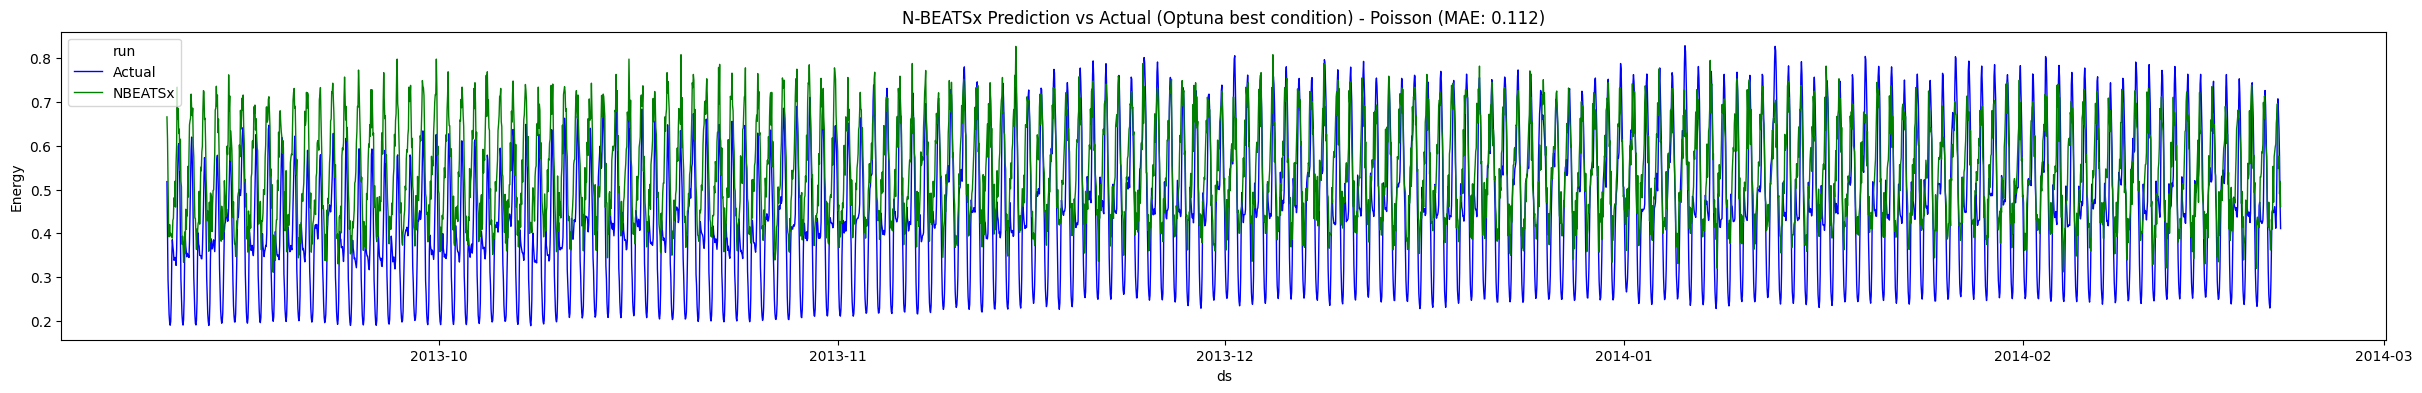

In [ ]:
df_pred_melt = pd.melt(p, id_vars=['ds'], value_vars=['y', 'NBEATSx'], var_name='run', value_name='Energy')
df_pred_melt.replace(to_replace='y', value="Actual", inplace = True)


title = "N-BEATSx Prediction vs Actual (Optuna best condition) - Poisson (MAE: 0.112)"

plt.figure(figsize=(30,4))
ax = sns.lineplot(data = df_pred_melt, x = 'ds', y = 'Energy', hue = 'run', palette= ['b', 'g'], linewidth = 1)
ax.set_title(title)
plt.show()

### Optuna Tuning (Loss Function: MAE)

In [ ]:
# Create function for Optuna tuning (MAE)

h = val['ds'].nunique()

def objective(trial):

    input_size = trial.suggest_int('input_size', 1, 60)

    n_blocks_season = trial.suggest_int('n_blocks_season', 1, 3)
    n_blocks_trend = trial.suggest_int('n_blocks_trend', 1, 3)
    n_blocks_identity = trial.suggest_int('n_blocks_ident', 1, 3)

    mlp_units_n = trial.suggest_categorical('mlp_units', [32, 64, 128])
    num_hidden = trial.suggest_int('num_hidden', 1, 3)

    n_harmonics = trial.suggest_int('n_harmonics', 1, 5)
    n_polynomials = trial.suggest_int('n_polynomials', 1, 5)

    scaler_type = trial.suggest_categorical('scaler_type', ['standard', 'robust'])
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


    n_blocks = [n_blocks_season, n_blocks_trend, n_blocks_identity]
    mlp_units=[[mlp_units_n, mlp_units_n]]*num_hidden
    models = [NBEATSx(h=h,input_size=input_size,
              loss=MAE(),
              max_steps=100,
              hist_exog_list=['holiday', 'temperature', 'humidity', 'windSpeed'],
              futr_exog_list=['holiday', 'temperature', 'humidity', 'windSpeed'],
              stack_types=['seasonality', 'trend', 'identity'],
              mlp_units=mlp_units,
              n_blocks=n_blocks,
              learning_rate=learning_rate,
              n_harmonics=n_harmonics,
              n_polynomials=n_polynomials,
              scaler_type=scaler_type)
              ]
    model = NeuralForecast(models=models, freq='H')
    model.fit(train)

    p_mae = model.predict(futr_df=val).reset_index()
    p_mae = p_mae.merge(val[['ds', 'unique_id', 'y']], on=['ds', 'unique_id'], how='left')

    loss_mae = mean_absolute_error(p_mae['y'], p_mae['NBEATSx'])
    rmse_mae = mean_squared_error(p_mae['y'], p_mae['NBEATSx'], squared=False)
    mape = mean_absolute_percentage_error(p_mae['y'], p_mae['NBEATSx'])

    input_size_value.append(input_size)
    n_blocks_season_value.append(n_blocks_season)
    n_blocks_trend_value.append(n_blocks_trend)
    n_blocks_identity_value.append(n_blocks_identity)
    mlp_units_value.append(mlp_units_n)
    num_hidden_value.append(num_hidden)
    n_harmonics_value.append(n_harmonics)
    n_polynomials_value.append(n_polynomials)
    scaler_type_value.append(scaler_type)
    learning_rate_value.append(learning_rate)
    MAE_value.append(loss_mae)
    RMSE_value.append(rmse_mae)
    MAPE_value.append(mape)
    Loss_Fn.append("MAE")

    return loss_mae

input_size_value = []
n_blocks_season_value = []
n_blocks_trend_value = []
n_blocks_identity_value = []
mlp_units_value = []
num_hidden_value = []
n_harmonics_value = []
n_polynomials_value = []
scaler_type_value = []
learning_rate_value = []
MAE_value = []
RMSE_value = []
MAPE_value = []
Loss_Fn = []

In [ ]:
# MAE

eval = optuna.create_study(direction='minimize')
eval.optimize(objective, n_trials=30)

[I 2024-02-24 00:57:12,073] A new study created in memory with name: no-name-e6bded1e-eccd-4736-87fe-e5cee1bffbba
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 00:57:26,388] Trial 0 finished with value: 0.09489759520171973 and parameters: {'input_size': 57, 'n_blocks_season': 2, 'n_blocks_trend': 1, 'n_blocks_ident': 3, 'mlp_units': 128, 'num_hidden': 3, 'n_harmonics': 1, 'n_polynomials': 2, 'scaler_type': 'standard', 'learning_rate': 0.0005098776486341039}. Best is trial 0 with value: 0.09489759520171973.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 00:58:01,175] Trial 1 finished with value: 0.3305552844098001 and parameters: {'input_size': 10, 'n_blocks_season': 3, 'n_blocks_trend': 1, 'n_blocks_ident': 3, 'mlp_units': 64, 'num_hidden': 2, 'n_harmonics': 3, 'n_polynomials': 2, 'scaler_type': 'robust', 'learning_rate': 0.0009514040940178827}. Best is trial 0 with value: 0.09489759520171973.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 00:58:13,820] Trial 2 finished with value: 1.3929567261232705 and parameters: {'input_size': 26, 'n_blocks_season': 1, 'n_blocks_trend': 2, 'n_blocks_ident': 2, 'mlp_units': 64, 'num_hidden': 1, 'n_harmonics': 2, 'n_polynomials': 2, 'scaler_type': 'standard', 'learning_rate': 2.55146705712513e-05}. Best is trial 0 with value: 0.09489759520171973.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 00:58:30,293] Trial 3 finished with value: 1.5290305632773575 and parameters: {'input_size': 6, 'n_blocks_season': 1, 'n_blocks_trend': 3, 'n_blocks_ident': 2, 'mlp_units': 128, 'num_hidden': 3, 'n_harmonics': 3, 'n_polynomials': 2, 'scaler_type': 'standard', 'learning_rate': 0.0019753238452899515}. Best is trial 0 with value: 0.09489759520171973.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 00:58:48,391] Trial 4 finished with value: 0.5417528172795834 and parameters: {'input_size': 40, 'n_blocks_season': 2, 'n_blocks_trend': 2, 'n_blocks_ident': 3, 'mlp_units': 32, 'num_hidden': 1, 'n_harmonics': 1, 'n_polynomials': 5, 'scaler_type': 'robust', 'learning_rate': 5.379624111865688e-05}. Best is trial 0 with value: 0.09489759520171973.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 00:59:01,830] Trial 5 finished with value: 0.16631917134378704 and parameters: {'input_size': 52, 'n_blocks_season': 2, 'n_blocks_trend': 1, 'n_blocks_ident': 2, 'mlp_units': 32, 'num_hidden': 3, 'n_harmonics': 1, 'n_polynomials': 2, 'scaler_type': 'standard', 'learning_rate': 0.0005559011315718096}. Best is trial 0 with value: 0.09489759520171973.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 00:59:24,829] Trial 6 finished with value: 0.23764466447839577 and parameters: {'input_size': 49, 'n_blocks_season': 1, 'n_blocks_trend': 2, 'n_blocks_ident': 1, 'mlp_units': 128, 'num_hidden': 1, 'n_harmonics': 4, 'n_polynomials': 4, 'scaler_type': 'robust', 'learning_rate': 0.00017492658693522552}. Best is trial 0 with value: 0.09489759520171973.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 01:00:02,545] Trial 7 finished with value: 0.4599022839949175 and parameters: {'input_size': 40, 'n_blocks_season': 3, 'n_blocks_trend': 3, 'n_blocks_ident': 3, 'mlp_units': 64, 'num_hidden': 3, 'n_harmonics': 3, 'n_polynomials': 3, 'scaler_type': 'robust', 'learning_rate': 5.1887615296625235e-05}. Best is trial 0 with value: 0.09489759520171973.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 01:00:21,784] Trial 8 finished with value: 29.577163636451882 and parameters: {'input_size': 42, 'n_blocks_season': 3, 'n_blocks_trend': 2, 'n_blocks_ident': 1, 'mlp_units': 64, 'num_hidden': 1, 'n_harmonics': 1, 'n_polynomials': 5, 'scaler_type': 'robust', 'learning_rate': 0.008774805576521405}. Best is trial 0 with value: 0.09489759520171973.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 01:00:47,566] Trial 9 finished with value: 0.1708202453907057 and parameters: {'input_size': 12, 'n_blocks_season': 2, 'n_blocks_trend': 1, 'n_blocks_ident': 1, 'mlp_units': 32, 'num_hidden': 3, 'n_harmonics': 3, 'n_polynomials': 3, 'scaler_type': 'robust', 'learning_rate': 0.019958306819450468}. Best is trial 0 with value: 0.09489759520171973.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 01:01:24,417] Trial 10 finished with value: 2248.001402757997 and parameters: {'input_size': 57, 'n_blocks_season': 2, 'n_blocks_trend': 1, 'n_blocks_ident': 3, 'mlp_units': 128, 'num_hidden': 2, 'n_harmonics': 5, 'n_polynomials': 1, 'scaler_type': 'standard', 'learning_rate': 0.05108270218213518}. Best is trial 0 with value: 0.09489759520171973.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 01:01:36,505] Trial 11 finished with value: 0.20092698617552107 and parameters: {'input_size': 60, 'n_blocks_season': 2, 'n_blocks_trend': 1, 'n_blocks_ident': 2, 'mlp_units': 32, 'num_hidden': 3, 'n_harmonics': 1, 'n_polynomials': 1, 'scaler_type': 'standard', 'learning_rate': 0.0004915709096298365}. Best is trial 0 with value: 0.09489759520171973.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 01:01:56,181] Trial 12 finished with value: 0.1241328734405769 and parameters: {'input_size': 51, 'n_blocks_season': 2, 'n_blocks_trend': 1, 'n_blocks_ident': 2, 'mlp_units': 128, 'num_hidden': 2, 'n_harmonics': 2, 'n_polynomials': 2, 'scaler_type': 'standard', 'learning_rate': 0.0024478870377706865}. Best is trial 0 with value: 0.09489759520171973.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 01:02:18,650] Trial 13 finished with value: 0.12593233099744836 and parameters: {'input_size': 27, 'n_blocks_season': 2, 'n_blocks_trend': 1, 'n_blocks_ident': 2, 'mlp_units': 128, 'num_hidden': 2, 'n_harmonics': 2, 'n_polynomials': 1, 'scaler_type': 'standard', 'learning_rate': 0.00493833769684025}. Best is trial 0 with value: 0.09489759520171973.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 01:02:51,253] Trial 14 finished with value: 0.13096743813015937 and parameters: {'input_size': 49, 'n_blocks_season': 3, 'n_blocks_trend': 1, 'n_blocks_ident': 3, 'mlp_units': 128, 'num_hidden': 2, 'n_harmonics': 2, 'n_polynomials': 3, 'scaler_type': 'standard', 'learning_rate': 0.0028698560165184676}. Best is trial 0 with value: 0.09489759520171973.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 01:03:06,430] Trial 15 finished with value: 0.2035572751628933 and parameters: {'input_size': 34, 'n_blocks_season': 1, 'n_blocks_trend': 2, 'n_blocks_ident': 2, 'mlp_units': 128, 'num_hidden': 2, 'n_harmonics': 2, 'n_polynomials': 4, 'scaler_type': 'standard', 'learning_rate': 0.00021935751419406089}. Best is trial 0 with value: 0.09489759520171973.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 01:03:28,702] Trial 16 finished with value: 1.8964158654801808 and parameters: {'input_size': 21, 'n_blocks_season': 2, 'n_blocks_trend': 1, 'n_blocks_ident': 3, 'mlp_units': 128, 'num_hidden': 2, 'n_harmonics': 2, 'n_polynomials': 2, 'scaler_type': 'standard', 'learning_rate': 1.0812881878864702e-05}. Best is trial 0 with value: 0.09489759520171973.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 01:04:13,150] Trial 17 finished with value: 1.1754604056934117 and parameters: {'input_size': 55, 'n_blocks_season': 3, 'n_blocks_trend': 3, 'n_blocks_ident': 1, 'mlp_units': 128, 'num_hidden': 3, 'n_harmonics': 4, 'n_polynomials': 4, 'scaler_type': 'standard', 'learning_rate': 0.0165432190593721}. Best is trial 0 with value: 0.09489759520171973.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 01:04:27,610] Trial 18 finished with value: 0.24111740757646652 and parameters: {'input_size': 45, 'n_blocks_season': 2, 'n_blocks_trend': 1, 'n_blocks_ident': 2, 'mlp_units': 128, 'num_hidden': 2, 'n_harmonics': 1, 'n_polynomials': 1, 'scaler_type': 'standard', 'learning_rate': 0.0002063894021016426}. Best is trial 0 with value: 0.09489759520171973.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 01:04:41,347] Trial 19 finished with value: 4027.9318313305175 and parameters: {'input_size': 35, 'n_blocks_season': 1, 'n_blocks_trend': 2, 'n_blocks_ident': 2, 'mlp_units': 128, 'num_hidden': 2, 'n_harmonics': 2, 'n_polynomials': 2, 'scaler_type': 'standard', 'learning_rate': 0.09474406001017961}. Best is trial 0 with value: 0.09489759520171973.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 01:04:56,076] Trial 20 finished with value: 0.07162861989100629 and parameters: {'input_size': 60, 'n_blocks_season': 2, 'n_blocks_trend': 1, 'n_blocks_ident': 3, 'mlp_units': 128, 'num_hidden': 3, 'n_harmonics': 1, 'n_polynomials': 3, 'scaler_type': 'standard', 'learning_rate': 0.001138224409655239}. Best is trial 20 with value: 0.07162861989100629.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 01:05:10,532] Trial 21 finished with value: 0.0651849571850871 and parameters: {'input_size': 60, 'n_blocks_season': 2, 'n_blocks_trend': 1, 'n_blocks_ident': 3, 'mlp_units': 128, 'num_hidden': 3, 'n_harmonics': 1, 'n_polynomials': 3, 'scaler_type': 'standard', 'learning_rate': 0.001602818494080272}. Best is trial 21 with value: 0.0651849571850871.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 01:05:25,086] Trial 22 finished with value: 0.06944640937179164 and parameters: {'input_size': 60, 'n_blocks_season': 2, 'n_blocks_trend': 1, 'n_blocks_ident': 3, 'mlp_units': 128, 'num_hidden': 3, 'n_harmonics': 1, 'n_polynomials': 3, 'scaler_type': 'standard', 'learning_rate': 0.0011374318663182302}. Best is trial 21 with value: 0.0651849571850871.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 01:05:39,797] Trial 23 finished with value: 0.06800162122508997 and parameters: {'input_size': 60, 'n_blocks_season': 2, 'n_blocks_trend': 1, 'n_blocks_ident': 3, 'mlp_units': 128, 'num_hidden': 3, 'n_harmonics': 1, 'n_polynomials': 3, 'scaler_type': 'standard', 'learning_rate': 0.0013539233452647052}. Best is trial 21 with value: 0.0651849571850871.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 01:05:55,059] Trial 24 finished with value: 0.13654932815225138 and parameters: {'input_size': 54, 'n_blocks_season': 2, 'n_blocks_trend': 1, 'n_blocks_ident': 3, 'mlp_units': 128, 'num_hidden': 3, 'n_harmonics': 1, 'n_polynomials': 4, 'scaler_type': 'standard', 'learning_rate': 0.007127251261318528}. Best is trial 21 with value: 0.0651849571850871.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 01:06:12,939] Trial 25 finished with value: 0.08383699886816612 and parameters: {'input_size': 46, 'n_blocks_season': 3, 'n_blocks_trend': 2, 'n_blocks_ident': 3, 'mlp_units': 128, 'num_hidden': 3, 'n_harmonics': 1, 'n_polynomials': 3, 'scaler_type': 'standard', 'learning_rate': 0.001106098322202517}. Best is trial 21 with value: 0.0651849571850871.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 01:06:32,472] Trial 26 finished with value: 0.12610074403757834 and parameters: {'input_size': 59, 'n_blocks_season': 1, 'n_blocks_trend': 1, 'n_blocks_ident': 3, 'mlp_units': 128, 'num_hidden': 3, 'n_harmonics': 4, 'n_polynomials': 4, 'scaler_type': 'standard', 'learning_rate': 0.004247022908595229}. Best is trial 21 with value: 0.0651849571850871.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 01:06:52,739] Trial 27 finished with value: 0.08363650835527192 and parameters: {'input_size': 54, 'n_blocks_season': 2, 'n_blocks_trend': 1, 'n_blocks_ident': 3, 'mlp_units': 128, 'num_hidden': 3, 'n_harmonics': 2, 'n_polynomials': 3, 'scaler_type': 'standard', 'learning_rate': 0.001803141642125614}. Best is trial 21 with value: 0.0651849571850871.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 01:07:28,275] Trial 28 finished with value: 0.9268454202684628 and parameters: {'input_size': 47, 'n_blocks_season': 2, 'n_blocks_trend': 2, 'n_blocks_ident': 3, 'mlp_units': 32, 'num_hidden': 3, 'n_harmonics': 5, 'n_polynomials': 3, 'scaler_type': 'standard', 'learning_rate': 0.00010068058726320839}. Best is trial 21 with value: 0.0651849571850871.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 01:07:38,388] Trial 29 finished with value: 0.316375627292731 and parameters: {'input_size': 19, 'n_blocks_season': 1, 'n_blocks_trend': 1, 'n_blocks_ident': 3, 'mlp_units': 64, 'num_hidden': 3, 'n_harmonics': 1, 'n_polynomials': 4, 'scaler_type': 'standard', 'learning_rate': 0.00041497938694671333}. Best is trial 21 with value: 0.0651849571850871.


In [ ]:
eval.best_params

{'input_size': 60,
 'n_blocks_season': 2,
 'n_blocks_trend': 1,
 'n_blocks_ident': 3,
 'mlp_units': 128,
 'num_hidden': 3,
 'n_harmonics': 1,
 'n_polynomials': 3,
 'scaler_type': 'standard',
 'learning_rate': 0.001602818494080272}

In [ ]:
eval.best_value

0.0651849571850871

In [ ]:
dict_results_mae = {'input_size': input_size_value, 'n_blocks_season': n_blocks_season_value, 'n_blocks_trend': n_blocks_trend_value, \
                    'n_blocks_identity': n_blocks_identity_value, 'mlp_units': mlp_units_value, 'num_hidden': num_hidden_value,  \
                    'n_harmonics': n_harmonics_value, 'n_polynomials': n_polynomials_value, 'scaler_type': scaler_type_value,  \
                    'learning_rate': learning_rate_value, 'MAE': MAE_value, 'RMSE': RMSE_value, 'MAPE': MAPE_value, 'Loss Fn': Loss_Fn}

df_results_mae = pd.DataFrame(dict_results_mae)
df_results_mae

,input_size,n_blocks_season,n_blocks_trend,n_blocks_identity,mlp_units,num_hidden,n_harmonics,n_polynomials,scaler_type,learning_rate,MAE,RMSE,MAPE,Loss Fn
0,57,2,1,3,128,3,1,2,standard,0.000510,0.094898,0.112526,0.265651,MAE
1,10,3,1,3,64,2,3,2,robust,0.000951,0.330555,0.412533,0.835410,MAE
2,26,1,2,2,64,1,2,2,standard,0.000026,1.392957,1.749006,3.508611,MAE
3,6,1,3,2,128,3,3,2,standard,0.001975,1.529031,1.810150,3.872829,MAE
4,40,2,2,3,32,1,1,5,robust,0.000054,0.541753,0.681974,1.364917,MAE
5,52,2,1,2,32,3,1,2,standard,0.000556,0.166319,0.213124,0.449511,MAE
6,49,1,2,1,128,1,4,4,robust,0.000175,0.237645,0.308617,0.579992,MAE
7,40,3,3,3,64,3,3,3,robust,0.000052,0.459902,0.611378,1.116687,MAE
8,42,3,2,1,64,1,1,5,robust,0.008775,29.577164,37.938972,75.353003,MAE
9,12,2,1,1,32,3,3,3,robust,0.019958,0.170820,0.202494,0.523917,MAE


In [ ]:
df_results_mae.to_csv(user_folder + "hourly_results_NBEATSx_Optuna_MAE.csv", index = False)

In [ ]:
# Check best param plot

h = val['ds'].nunique()

input_size = 60

n_blocks_season = 2
n_blocks_trend = 1
n_blocks_identity = 3

mlp_units_n = 128
num_hidden = 3

n_harmonics = 1
n_polynomials = 3

scaler_type = 'standard'
learning_rate = 0.001602818494080272


n_blocks = [n_blocks_season, n_blocks_trend, n_blocks_identity]
mlp_units=[[mlp_units_n, mlp_units_n]]*num_hidden
models = [NBEATSx(h=h,input_size=input_size,
              loss=MAE(),
              max_steps=100,
              hist_exog_list=['holiday', 'temperature', 'humidity', 'windSpeed'],
              futr_exog_list=['holiday', 'temperature', 'humidity', 'windSpeed'],
              stack_types=['seasonality', 'trend', 'identity'],
              mlp_units=mlp_units,
              n_blocks=n_blocks,
              learning_rate=learning_rate,
              n_harmonics=n_harmonics,
              n_polynomials=n_polynomials,
              scaler_type=scaler_type)
              ]
model = NeuralForecast(models=models, freq='H')
model.fit(train)

p_mae = model.predict(futr_df=val).reset_index()
p_mae = p_mae.merge(val[['ds', 'unique_id', 'y']], on=['ds', 'unique_id'], how='left')

loss_mae = mean_absolute_error(p_mae['y'], p_mae['NBEATSx'])

INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
print(loss_mae)
p_mae

0.0651849571850871


,unique_id,ds,NBEATSx,y
0,1,2013-09-09 21:00:00,0.535219,0.518124
1,1,2013-09-09 22:00:00,0.518309,0.404168
2,1,2013-09-09 23:00:00,0.421856,0.294621
3,1,2013-09-10 00:00:00,0.364089,0.251980
4,1,2013-09-10 01:00:00,0.326752,0.214183
...,...,...,...,...
3935,1,2014-02-20 20:00:00,0.729965,0.676087
3936,1,2014-02-20 21:00:00,0.669639,0.638370
3937,1,2014-02-20 22:00:00,0.588636,0.574031
3938,1,2014-02-20 23:00:00,0.499688,0.470768


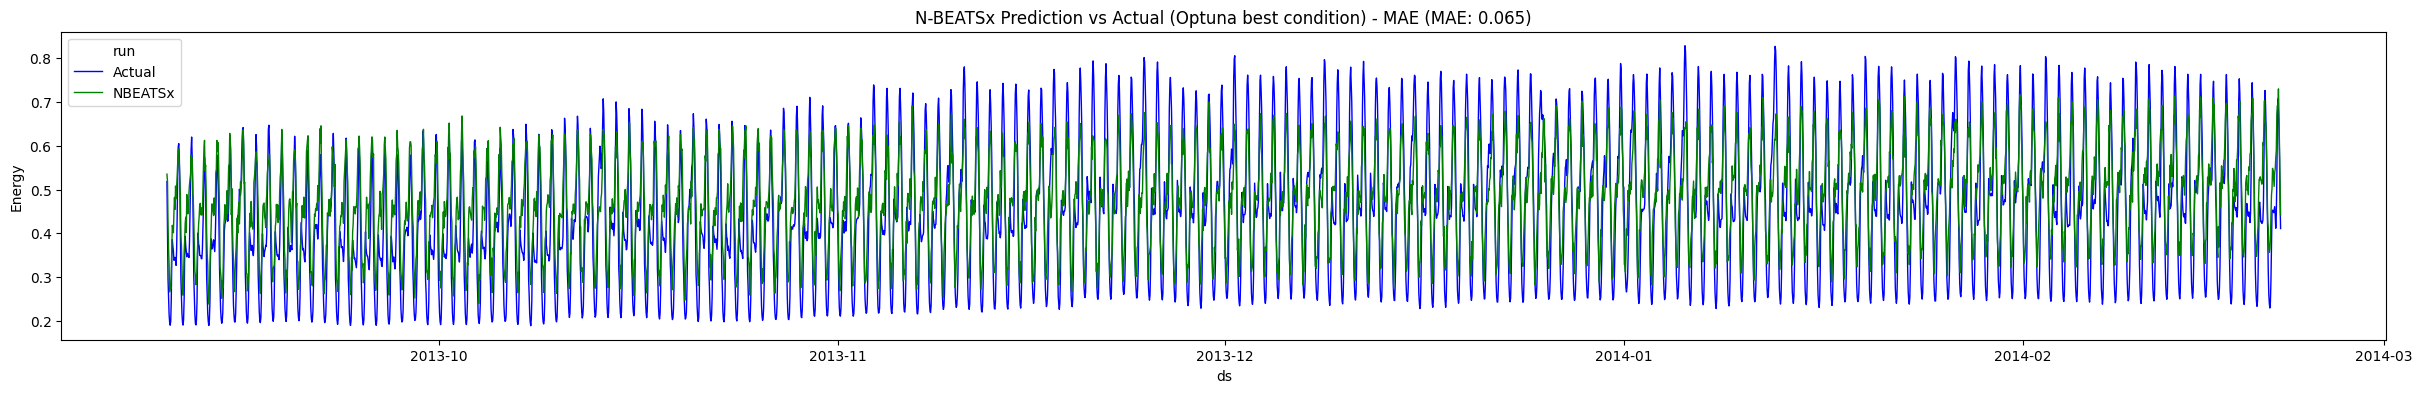

In [ ]:
df_pred_melt_mae = pd.melt(p_mae, id_vars=['ds'], value_vars=['y', 'NBEATSx'], var_name='run', value_name='Energy')
df_pred_melt_mae.replace(to_replace='y', value="Actual", inplace = True)


title = "N-BEATSx Prediction vs Actual (Optuna best condition) - MAE (MAE: 0.065)"

plt.figure(figsize=(30,4))
ax = sns.lineplot(data = df_pred_melt_mae, x = 'ds', y = 'Energy', hue = 'run', palette= ['b', 'g'], linewidth = 1)
ax.set_title(title)
plt.show()